This notebook tests the python btrack module.

In [2]:
from midap.tracking.bayesian_tracking import BayesianCellTracking

import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.measure import regionprops
from scipy.spatial import distance
import pandas as pd
import os

### Load segmentations

In [3]:
# Load data
path = '../example_data/Pos58/TXRED'
images_folder = os.path.join(path, 'cut_im')
segmentation_folder = os.path.join(path, 'seg_im')

# glob all the cut images and segmented images
img_names_sort = np.sort(glob.glob(os.path.join(images_folder, '*frame*.png')))
seg_names_sort = np.sort(glob.glob(os.path.join(segmentation_folder, '*frame*.png')))

# Parameters:
crop_size = (128, 128)
target_size = (512, 512)
input_size = crop_size + (4,)
num_time_steps = len(img_names_sort)

### Run the tracking

In [4]:
tracker_obj = BayesianCellTracking(imgs=img_names_sort, segs=seg_names_sort, target_size=target_size)
tracker_obj.run_model()
#tracker_obj.tracker.tracks

[INFO][2022/12/07 09:44:00 PM] Localizing objects from segmentation...
[INFO][2022/12/07 09:44:00 PM] Found intensity_image data
[INFO][2022/12/07 09:44:00 PM] Calculating weighted centroids using intensity_image
[INFO][2022/12/07 09:44:01 PM] Objects are of type: <class 'dict'>
[INFO][2022/12/07 09:44:01 PM] ...Found 504 objects in 9 frames.
[INFO][2022/12/07 09:44:01 PM] Loaded btrack: /Users/franziskaoschmann/miniconda3/envs/midap/lib/python3.8/site-packages/btrack/libs/libtracker.dylib
[INFO][2022/12/07 09:44:01 PM] btrack (v0.4.6) library imported
[INFO][2022/12/07 09:44:01 PM] Starting BayesianTracker session
[INFO][2022/12/07 09:44:01 PM] Setting update_method -> BayesianUpdates.EXACT
[INFO][2022/12/07 09:44:01 PM] Loading configuration file: /Users/franziskaoschmann/Library/Caches/btrack-examples/examples/cell_config.json
[INFO][2022/12/07 09:44:01 PM] Setting max_search_radius -> 200
[INFO][2022/12/07 09:44:01 PM] Setting features -> ['area', 'major_axis_length', 'minor_axis_l

GLPK Integer Optimizer 5.0
300 rows, 231 columns, 313 non-zeros
231 integer variables, all of which are binary
Preprocessing...
150 rows, 231 columns, 313 non-zeros
231 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 150
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
150 rows, 231 columns, 313 non-zeros
*     0: obj =   1.120165966e+02 inf =   0.000e+00 (17)
*    16: obj =   6.233112201e+01 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+    16: mip =     not found yet >=              -inf        (1; 0)
+    16: >>>>>   6.233112201e+01 >=   6.233112201e+01   0.0% (1; 0)
+    16: mip =   6.233112201e+01 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTION FOUND


### Inspecting the output

In [5]:
tracker_obj.tracks[-2]

,ID,t,x,y,z,parent,root,state,generation,dummy,minor_axis_length,major_axis_length,area,intensity_max,intensity_min,orientation,coords,intensity_mean
0,73,8,371.608779,105.140099,0.0,13,13,5,1,False,"(1,) array","(1,) array","(1,) array","(1,) array","(1,) array","(1,) array","(1, 91, 2) array","(1,) array"


### Visualizing the tracking

In [6]:
tracker_obj.generate_label_stack()
tracker_obj.convert_data()

In [13]:
# outp_conv = pd.DataFrame({'frame' : time, 'trackID':trackID, 
#                           'trackID_d1':trackID_d1, 
#                           'trackID_d2':trackID_d2, 
#                           'trackID_mother':trackID_mother, 
#                           'area':area, 
#                           'x':x_coor, 
#                           'y':y_coor,
#                           # 'intensity_mean':intensity_mean,
#                           # 'intensity_min':intensity_min,
#                           # 'intensity_max':intensity_max,
#                           'first_frame':first_frame, 
#                           'last_frame':last_frame})
# outp_conv

In [14]:
# df = outp_conv.groupby(['frame', 'trackID']).aggregate({'frame':'first',
#                                                         'trackID':'first',
#                                                         'trackID_d1':'first',
#                                                         'trackID_d2':'last',
#                                                         'trackID_mother':'first', 
#                                                         'area':'first',
#                                                         'x':'first',
#                                                         'y':'first',
#                                                         # 'intensity_mean':'first',
#                                                         # 'intensity_min':'first',
#                                                         # 'intensity_max':'first',
#                                                         'first_frame':'first',
#                                                         'last_frame':'first'}).reindex(columns=outp_conv.columns)
# df

In [15]:
# def find_nearest_neighbour(point, seg):
#     centroids = [r.centroid for r in regionprops(seg)]
#     labels = [r.label for r in regionprops(seg)]
#     ix_min = np.argmin([distance.euclidean(c, point) for c in centroids])
#     ix_cell = np.where(seg == labels[ix_min])
#     return ix_cell

In [16]:
# label_stack = np.zeros(segmentation.shape)
# for tr in tracker_obj.tracks:
#     for i in range(len(tr['t'])):
#         #print(tr)
#         point = (int(tr['y'][i]), int(tr['x'][i]))
#         label_stack[i][find_nearest_neighbour(point, segmentation[i])] = tr['ID']

In [17]:
label_stack = tracker_obj.label_stack

In [18]:
np.unique(label_stack[-1])

array([ 0.,  1.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 14., 15.,
       16., 17., 18., 20., 21., 22., 23., 24., 25., 26., 27., 29., 30.,
       31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 44.,
       45., 46., 47., 49., 50., 52., 53., 54., 57., 59., 60., 61., 64.,
       65., 66., 67., 68., 69., 70., 72., 73., 74.])

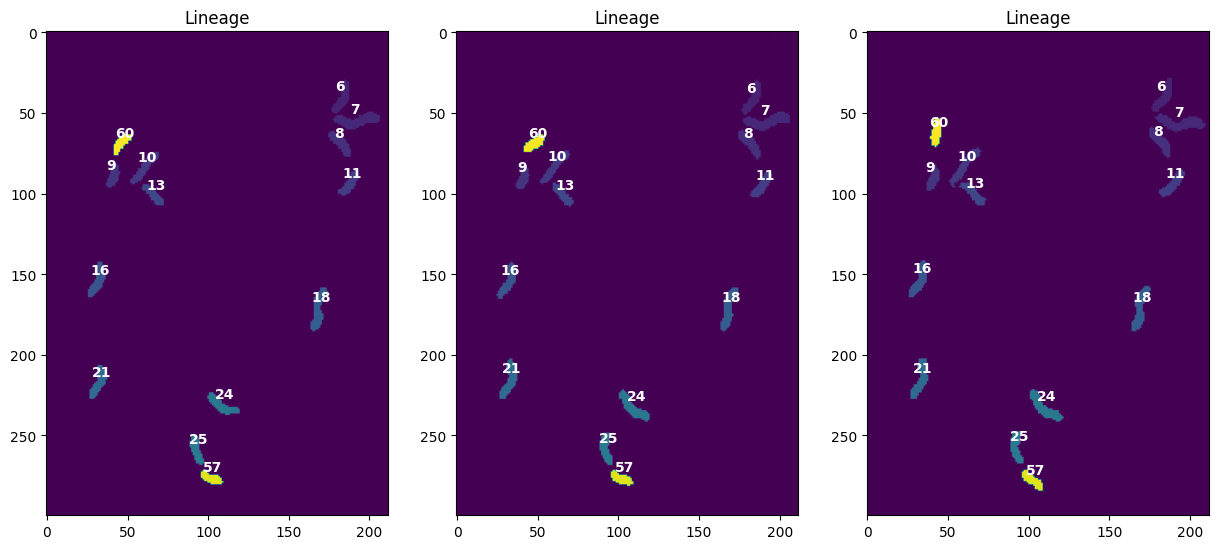

In [25]:
plt.figure(figsize=(15,10))
ax = plt.subplot(1,3,1)
img = label_stack[3][:300,300:]
plt.imshow(img)
plt.title('Lineage')
reg = regionprops(img.astype(int))
center = [r.centroid for r in reg]
labels = [r.label for r in reg]
for c, l in zip(center, labels):
    x, y = c
    x=int(np.ceil(x))
    y=int(np.ceil(y))
    ax.text(y-5,x-5, str(l), color='w', weight='bold')

ax = plt.subplot(1,3,2)
img = label_stack[4][:300,300:]
plt.imshow(img)
plt.title('Lineage')
reg = regionprops(img.astype(int))
center = [r.centroid for r in reg]
labels = [r.label for r in reg]
for c, l in zip(center, labels):
    x, y = c
    x=int(np.ceil(x))
    y=int(np.ceil(y))
    ax.text(y-5,x-5, str(l), color='w', weight='bold')

ax = plt.subplot(1,3,3)
img = label_stack[5][:300,300:]
plt.imshow(img)
plt.title('Lineage')
reg = regionprops(img.astype(int))
center = [r.centroid for r in reg]
labels = [r.label for r in reg]
for c, l in zip(center, labels):
    x, y = c
    x=int(np.ceil(x))
    y=int(np.ceil(y))
    ax.text(y-5,x-5, str(l), color='w', weight='bold')

(8, 2)
(115, 2)
(178, 2)
(107, 2)
(78, 2)
(122, 2)
(82, 2)
(98, 2)
(83, 2)
(119, 2)
(148, 2)
(109, 2)
(115, 2)
(94, 2)
(75, 2)


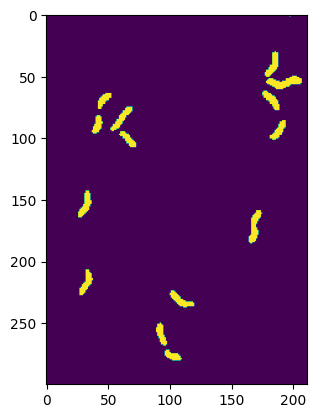

In [20]:
from skimage.measure import label, regionprops
plt.imshow(tracker_obj.seg_imgs[3][:300,300:])

reg = regionprops(label(tracker_obj.seg_imgs[3][:300,300:]))

recreat = np.zeros(tracker_obj.seg_imgs[3][:300,300:].shape)

for r in reg:
    recreat[r.coords[:,0],r.coords[:,1]] = 1
    print(r.coords.shape)

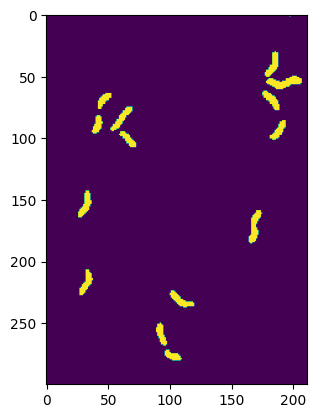

In [21]:
plt.imshow(recreat)

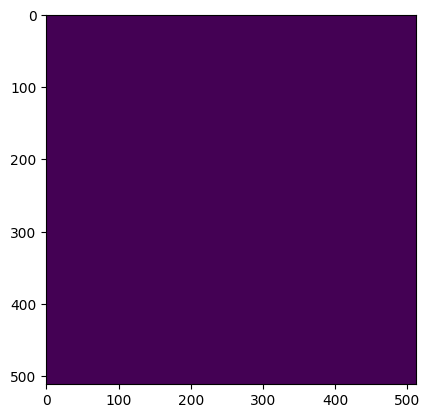

In [22]:
plt.imshow((label_stack[-1] > 0).astype(int) - tracker_obj.seg_imgs[-1])

In [23]:
import btrack

from btrack.constants import BayesianUpdates
from btrack.render import plot_tracks

plot_tracks(tracker_obj.tracker.tracks, order='xyt', box=box)

ModuleNotFoundError: No module named 'btrack.render'

In [ ]:
print(btrack.__version__)

In [ ]:
reg[0].coords